In [1]:
 conda update -n base -c defaults conda

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [2]:
conda install pytorch torchvision -c pytorch

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda




In [3]:
pip install typing_extensions

Note: you may need to restart the kernel to use updated packages.


# Step 1: Import the necessary Libraries

In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization 
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

# Step2: Loading the Dataset

In this step, we are using ‘yfinance’ library to download historical stock market data for Apple Inc. (AAPL) from Yahoo Finance.

In [5]:

# Loading the Apple.Inc Stock Data
 
import yfinance as yf
from datetime import date, timedelta, datetime 
 
end_date =  date.today().strftime("%Y-%m-%d") #end date for our data retrieval will be current date 
start_date = '1990-01-01' # Beginning date for our historical data retrieval 
 
df = yf.download('AAPL', start=start_date, end=end_date)# Function used to fetch the data 

[*********************100%%**********************]  1 of 1 completed


# Step 3: Data Preprocessing

 Plot the time series trend using Matplotlib

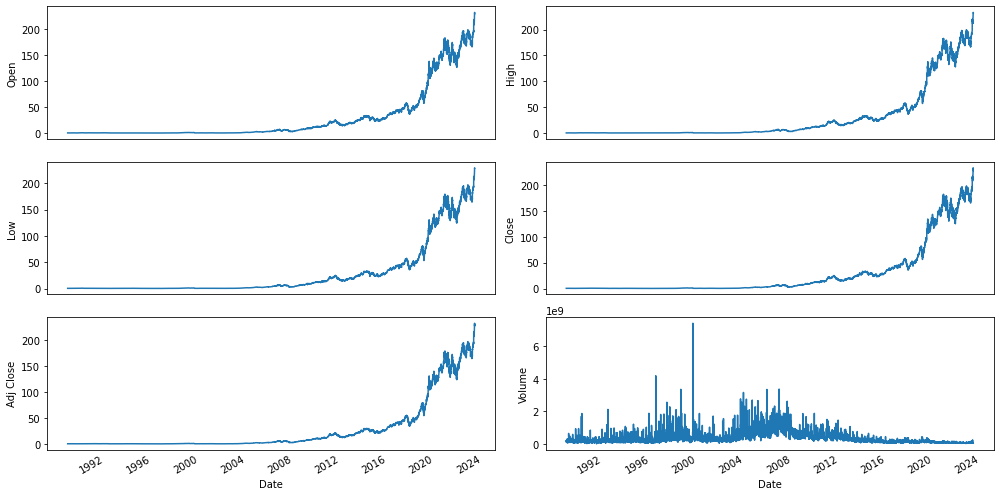

In [6]:
def data_plot(df):
    df_plot = df.copy()
 
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))
 
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()
 
data_plot(df)

# Splitting the dataset into test and train

 We calculate the length of the training datasets and print their respective shapes to confirm the split.

In [7]:
# Train-Test Split 
# Setting 80 percent data for training
training_data_len = math.ceil(len(df) * .8)
training_data_len
 
#Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6959, 1) (1739, 1)


# Preparing Training and Testing Dataset

We are choosing the feature (‘Open’ prices), reshaping it into the necessary 2D format,and validating the resulting shape to make sure it matches the anticipated format for model input,this method prepares the training data for use in a neural network.

# Training Data

In [8]:
# Selecting Open Price values
dataset_train = train_data.Open.values
# Reshaping 1D to 2D array
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(6959, 1)

# Testing Data

In [9]:
# Selecting Open Price values
dataset_test = test_data.Open.values
# Reshaping 1D to 2D array
dataset_test = np.reshape(dataset_test, (-1,1))
dataset_test.shape

(1739, 1)

# Normalization

We have applied Min-Max scaling which is a standard preprocessing step in machine learning and time series analysis, to the dataset_test data. It adjusts the values to be between [0, 1], allowing neural networks and other models to converge more quickly and function better. The normalized values are contained in the scaled_test array as a consequence, ready to be used in modeling or analysis.

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# scaling dataset
scaled_train = scaler.fit_transform(dataset_train)
 
print(scaled_train[:5])
# Normalizing values between 0 and 1
scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) #prints the first 5 rows of scaled_test

[[0.00501196]
 [0.00562797]
 [0.00568396]
 [0.00557197]
 [0.00551595]]
[0.01962692] [0.0213414] [0.0229791] [0.02116227] [0.0177589]


# Transforming the data into Sequence

In this step, it is necessary to separate the time-series data into X_train and y_train from the training set and X_test and y_test from the testing set. Time series data are transformed into a supervised learning problem that may be used to develop the model. While iterating through the time series data, the loop generates input/output sequences of length 50 for training data and sequences of length 30 for the test data. We can predict future values using this technique while taking into account the data’s temporal dependence on earlier observations.

In [11]:
# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([6909, 50, 1]), torch.Size([6909, 50, 1]))

# Testing Data

In [12]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([1709, 30, 1]), torch.Size([1709, 30, 1]))

# Step 4: Define LSTM class model

Now, we defined a PyTorch network using LSTM architecture. The class consist of LSTM layer and linear layer. 
The forward method defines the forward pass of the model, where the input x is processed through the layers of the model to produce an output.

In [13]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

# Check Hardware Availability

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Defining the model

Now, we define the model, loss function and optimizer for the forecasting. We have adjusted the hyperparameters of the model and set the loss fuction to mean squared error. To optimize the parameters during the training, we have considered Adam optimizer.

In [15]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


# Step 5: Creating Data Loader for batch training

Data loader play an essential role during the training and evaluation phase. So, we have prepared the data for batch training and testing by creating data loader objects.

In [16]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
# Create DataLoader for batch training
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 6: Model Training & Evaluations

Now, we built a training loop for 50 epochs. In the provided code snippet, the model processes mini batches of training data and compute loss and update the parameters.

In [17]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    # Validation on test data
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        # Calculate average test loss and accuracy
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [20/50] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [30/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [50/50] - Training Loss: 0.0000, Test Loss: 0.0001


# Plotting the Learning Curve

We have plotted the learning curve to track the progress and give us an idea, how much time time and training is required by the model to understand the patterns.

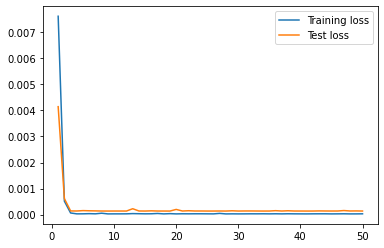

In [18]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

# Forecasting

After training the neural network on the provided data, now comes the forecasting for next month. The model predicts the future opening price and store the future values along with their corresponding dates. Using for loop, we are going to perform a rolling forecasting, the steps are as follows –

We have set the future time steps to 30 and converted the test sequence to numpy array and remove singleton dimensions using sequence_to_plot.
Then, we have converted historical_data to a Pytorch tensor. The shape of the tensor is (1, sequence_length, 1), where sequence_length is the length of the historical data sequence.
the model further predicts the next value based on the ‘historical_data_tensor’.
The prediction is then converted to a numpy array and the first element is extracted.

Once the loop ends, we get the forecasted values, which are stored in list, and future dates are generated to create index for these values.

In [23]:
# Define the number of future time steps to forecast
num_forecast_steps = 30
 
# Convert to NumPy and remove singleton dimensions
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
# Use the last 30 data points as the starting point
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
         
# Generate futute dates
last_date = test_data.index[-1]
 
# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

(30,)


# Last step: Plotting the Prediction Graph

Once, we have forecasted the future prices, we can visualize the same using line plots. We have plotted the graph for a specific time range. The blue line is the indicator of the test data. Then we plot the last 30-time steps of the test data index using the green colored line plot.

The forecasted values are plotted using red colored line plot that uses a combined index that includes both the historic data and future dates.

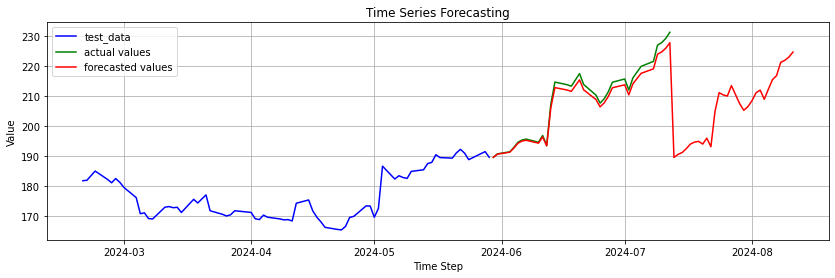

In [21]:
#set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 
 
 
#Test data
plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label = "test_data", color = "b") 
#reverse the scaling transformation
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
#the historical data used as input for forecasting
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 
 
#Forecasted Values 
#reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
# plotting the forecasted values
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')  
 
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

By plotting the test data, actual values and model’s forecasting data. We got a clear idea of how well the forecasted values are aligning with the actual time series.

The intriguing field of time series forecasting using PyTorch and LSTM neural networks has been thoroughly examined in this paper. In order to collect historical stock market data using Yahoo Finance module, we imported the yfinance library and started the preprocessing step. Then we applied crucial actions like data loading, train-test splitting, and data scaling to make sure our model could accurately learn from the data and make predictions.